# Algoritmo de Busqueda Jerarquica con filtro Fourier

In [8]:
import numpy as np
import cv2
import random
import pandas as pd
import time

import matplotlib.pyplot as plt
from seaborn import load_dataset

In [9]:
path= '../../Alejandro_Proyectos/'
pathReferencia ='Imagenes Originales Gris/Bridge_gray.png'
pathRuido='Bridge/Bridge_gray_512_512_variance_400.png'
imagenReferencia = cv2.imread(path+pathReferencia)
imagenReferenciaGris = cv2.cvtColor(imagenReferencia, cv2.COLOR_RGB2GRAY)
imagenRuido = cv2.imread(path+pathRuido)
imagenRuidoGris = cv2.cvtColor(imagenRuido, cv2.COLOR_RGB2GRAY)
areaBusqueda = 21
tamañoParche = 8
split_punto = pathRuido.split(".")
split_guion = split_punto[0].split("_")
varianzaOriginal = int(split_guion[len(split_guion)-1])

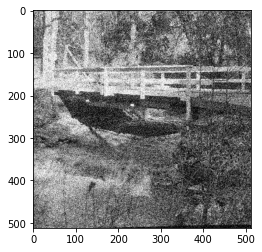

In [10]:
plt.imshow(cv2.cvtColor(imagenRuidoGris, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
def filtroFourier(imag):
    Nf = imag.shape[0]
    Nc = imag.shape[1]
    F1=np.arange(-Nf/2+1,Nf/2+1,1)
    F2=np.arange(-Nc/2+1,Nc/2+1,1)
    [X,Y]=np.meshgrid(F1,F2)
    #plt.plot(X,Y, marker='.', color='k', linestyle='none')
    D=np.sqrt(X**2+Y**2)
    D=D/np.max(D)
    #DEFINIR RADIO DE CORTE
    #Do=0.59 dependiendo el histograma de la imagen
    Do=.475
    #Creación del Filtro Ideal en 2D
    Huv=np.zeros((Nf,Nc))
    #PRIMERO CREAR EL FILTRO PASA BAJO IDEAL
    for i in range(Nf):
        for j in range(Nc):
            if(D[i,j]<Do):
                Huv[i,j]=1
#CONVERTIR A PASA ALTO IDEAL
#Huv=1-Huv
#----------------------------------------------------
#"FILTRO 2D PASA ALTO IDEAL"
#plt.imshow(np.uint8(255*Huv))
    imgD64 = np.float64(imag)
    Fourier = np.fft.fft2(imgD64)
    FourierShift = np.fft.fftshift(Fourier)
    Guv=Huv*FourierShift
    #MAGNITUD
    Guv_abs=np.abs(Guv)
    gxy=np.fft.ifft2(Guv)
    gxy=np.abs(gxy)
    gxy=np.uint8(gxy)
    return  gxy

In [5]:
def algoritmoBusquedaJerarquica(posicionAltoImagenActual,posicionAnchoImagenActual,imgAct,imgRuido,areaBus,tamParche):   
#     imgActBlur = cv2.GaussianBlur(imgAct,(5,5),0)  
    imagenActual = imgAct[posicionAltoImagenActual:posicionAltoImagenActual+tamParche, posicionAnchoImagenActual: posicionAnchoImagenActual+tamParche]
    imagenActualBlur = filtroFourier(imagenActual) # Esta parte se inserta dado que el artículo dice que se agrega un filtro suavizado

    dh1 = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    tiempo_Extra = 0
    inicio = time.time()
    for m in range(posicionAltoImagenActual,posicionAltoImagenActual+areaBus-tamParche+1):
        for n in range(posicionAnchoImagenActual,posicionAnchoImagenActual+areaBus-tamParche+1):
            inicio_extra = time.time()
            imagenReferencia = imgRuido[m:m+tamParche, n: n+tamParche]
            imagenReferenciaBlur = filtroFourier(imagenReferencia)
            lenParche=int(tamParche/2)
            ssd=0
            fin_extra = time.time()
            timeSee=fin_extra-inicio_extra
            tiempo_Extra = tiempo_Extra + timeSee
            for rx_Pache in range (0,lenParche):
                for ry_Pache in range (0,lenParche):
                    rx_Parche_int = int(2*(rx_Pache))
                    ry_Parche_int = int(2*(ry_Pache))
                    resta = int(imagenActualBlur[rx_Parche_int,ry_Parche_int])-int(imagenReferenciaBlur[rx_Parche_int,ry_Parche_int])
                    ssd += resta**2                  
#                     ssd += np.sum(np.power((imagenActualBlur[rx_Parche_int,ry_Parche_int]-imagenReferenciaBlur[rx_Parche_int,ry_Parche_int]),2))
            auxi = [ssd, m, n]
            dh2 = pd.DataFrame([auxi], columns=['ssd', 'coordenada_x', 'coordenada_y'])
            dh1= pd.concat([dh1, dh2], ignore_index=True)
#     print(posicionAltoImagenActual,posicionAnchoImagenActual)
    fin = time.time()
    time_1 = (fin-inicio)
    time_1 = time_1-tiempo_Extra
    by_ascending_ssd = dh1.sort_values('ssd',ascending=True)
    by_ascending_ssd = by_ascending_ssd.reset_index(drop=True)
    #by_ssd.head()
#     print(by_ascending_ssd)
    tiempo_Extra_2 = 0
    ##Aquí comienza la segunda etapa
    dhFefinitive = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    inicio_1 = time.time()
    for iteraLista in range(0,8):
        inicio_extra_2 = time.time()
        Alto_x = by_ascending_ssd['coordenada_x'][iteraLista]
        Alto_y = by_ascending_ssd['coordenada_y'][iteraLista]
        imagenReferenciaDos = imgRuido[Alto_x:Alto_x+tamParche, Alto_y: Alto_y+tamParche]
        imagenReferenciaDosBlur = filtroFourier(imagenReferenciaDos)
        fin_extra_2 = time.time()
        timeSee_2=fin_extra_2-inicio_extra_2
        tiempo_Extra_2 = tiempo_Extra_2 + timeSee_2
        ssd=0
        for i in range (0,tamParche):
            for j in range (0,tamParche):
                resta = int(imagenActualBlur[i,j])-int(imagenReferenciaDosBlur[i,j])
                ssd += resta**2                  
#                 ssd += np.sum(np.power((imagenActualBlur[i,j]-imagenReferenciaDosBlur[i,j]),2))
        auxi2 = [ssd, Alto_x, Alto_y]
        dhFefinitive2 = pd.DataFrame([auxi2], columns=['ssd', 'coordenada_x', 'coordenada_y'])
        dhFefinitive= pd.concat([dhFefinitive, dhFefinitive2], ignore_index=True)
    fin_1 = time.time()
    time_2 = (fin_1-inicio_1)
    time_2 = time_2-tiempo_Extra_2
#     print(time_1+time_2)
    by_ascending_dhFefinitive = dhFefinitive.sort_values('ssd', ascending=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.reset_index(drop=True)
#     print(by_ascending_dhFefinitive)
    posicionAltoImagenReferencia = by_ascending_dhFefinitive['coordenada_x'][0]
    posicionAnchoImagenReferencia = by_ascending_dhFefinitive['coordenada_y'][0]
    
    return posicionAltoImagenReferencia,posicionAnchoImagenReferencia

In [6]:
pxy_pref = pd.DataFrame(columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y',])
altoImagen = imagenReferenciaGris.shape[0]
anchoImagen = imagenReferenciaGris.shape[1]

for posicionAlto in range(0,altoImagen-areaBusqueda): # altoImagen-areaBusqueda
    for posicionAncho in range(0,anchoImagen-areaBusqueda): # anchoImagen-areaBusqueda
        posicionAltoImagenReferencia,posicionAnchoImagenReferencia = algoritmoBusquedaJerarquica(posicionAlto,posicionAncho,imagenReferenciaGris,imagenRuidoGris,areaBusqueda,tamañoParche)
        auxi3 = [posicionAlto, posicionAncho, posicionAltoImagenReferencia,posicionAnchoImagenReferencia]
        pxy_pref2 = pd.DataFrame([auxi3], columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y'])
        pxy_pref = pd.concat([pxy_pref, pxy_pref2], ignore_index=True)
    
    
        
pxy_pref
# plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
# plt.show()
#print(imagen)

,coordenada_x,coordenada_y,referencia_x,referencia_y
0,0,0,11,2
1,0,1,10,2
2,0,2,0,2
3,0,3,0,3
4,0,4,1,4
...,...,...,...,...
241076,490,486,493,486
241077,490,487,491,497
241078,490,488,491,497
241079,490,489,491,498


In [7]:
suma = 0
miu = 0
for i in range(0,len(pxy_pref)-1):
    if pxy_pref['coordenada_x'][i] == pxy_pref['referencia_x'][i] and pxy_pref['coordenada_y'][i] == pxy_pref['referencia_y'][i]:
        suma += 1
        
miu =  suma/(len(pxy_pref)-1)
miu
    

0.2704123112659698

# Algoritmo de Busqueda Jerarquica con transformada Fourier

In [11]:
def transformadaFourier(img1):
    img1_Fourier = img1.astype('float')
    #print(img1_Fourier,'Pixeles')
    Fourier = np.fft.fft2(img1_Fourier)
    #print(Fourier)
    FourierShift = np.fft.fftshift(Fourier)
    #print(FourierShift,'Fourier_Shift')
    #print(FourierShift)

    realFourierData = np.zeros((len(img1), len(img1)))

    for i in range(len(realFourierData)):
        for j in range(len(realFourierData)):
            realFourierData[i,j] = FourierShift[i,j].real

    #print(realFourierData,'Fourier_Real_Part')
    
    return realFourierData

In [12]:
def algoritmoBJTFD(posicionAltoImagenActual,posicionAnchoImagenActual,imgAct,imgRuido,areaBus,tamParche):
#     imagenActualFiltro = transformadaCosenoDiscreta(imgAct)
#     imagenRuidoFiltro = transformadaCosenoDiscreta(imgRuido)

    imagenActual = imgAct[posicionAltoImagenActual:posicionAltoImagenActual+tamParche, posicionAnchoImagenActual: posicionAnchoImagenActual+tamParche]
    imagenActualTFD = transformadaFourier(imagenActual)
    dh1 = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for m in range(posicionAltoImagenActual,posicionAltoImagenActual+areaBus-tamParche+1):
        for n in range(posicionAnchoImagenActual,posicionAnchoImagenActual+areaBus-tamParche+1):
            imagenReferencia = imgRuido[m:m+tamParche, n: n+tamParche]
            imagenReferenciaTFD = transformadaFourier(imagenReferencia)
            lenParche=6 
            ssd=0
            for rx_Pache in range (2,lenParche):
                for ry_Pache in range (2,lenParche):
                    resta = int(imagenActualTFD[rx_Pache,ry_Pache])-int(imagenReferenciaTFD[rx_Pache,ry_Pache])
                    ssd += resta**2
#                     ssd += np.sum(np.power((imagenActualTCD[rx_Pache,ry_Pache]-imagenReferenciaTCD[rx_Pache,ry_Pache]),2))
            auxi = [ssd, m, n]
            dh2 = pd.DataFrame([auxi], columns=['ssd', 'coordenada_x', 'coordenada_y'])
            dh1= pd.concat([dh1, dh2], ignore_index=True)
#     print(posicionAltoImagenActual,posicionAnchoImagenActual)
    by_ascending_ssd = dh1.sort_values('ssd',ascending=True)
    by_ascending_ssd = by_ascending_ssd.reset_index(drop=True)
    by_ascending_ssd = by_ascending_ssd.astype(int)
    #by_ssd.head()
#     print(by_ascending_ssd)
    
    ##Aquí comienza la segunda etapa
    dhFefinitive = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for iteraLista in range(0,8):
        Alto_x = by_ascending_ssd['coordenada_x'][iteraLista]
        Alto_y = by_ascending_ssd['coordenada_y'][iteraLista]
        imagenReferenciaDos = imgRuido[Alto_x:Alto_x+tamParche, Alto_y: Alto_y+tamParche]
        imagenReferenciaDosTFD = transformadaFourier(imagenReferenciaDos)
        ssd=0
        lenParche = 7
        for i in range (2,lenParche):
            for j in range (2,lenParche):
                resta = int(imagenActualTFD[i,j])-int(imagenReferenciaDosTFD[i,j])
                ssd += resta**2
#                 ssd += np.sum(np.power((imagenActualTCD[i,j]-imagenReferenciaDosTCD[i,j]),2))
        auxi2 = [ssd, Alto_x, Alto_y]
        dhFefinitive2 = pd.DataFrame([auxi2], columns=['ssd', 'coordenada_x', 'coordenada_y'])
        dhFefinitive= pd.concat([dhFefinitive, dhFefinitive2], ignore_index=True)
    by_ascending_dhFefinitive = dhFefinitive.sort_values('ssd', ascending=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.reset_index(drop=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.astype(int)
#     print(by_ascending_dhFefinitive)
    posicionAltoImagenReferencia = by_ascending_dhFefinitive['coordenada_x'][0]
    posicionAnchoImagenReferencia = by_ascending_dhFefinitive['coordenada_y'][0]
    
    return posicionAltoImagenReferencia,posicionAnchoImagenReferencia

In [13]:
pxy_pref_BJTFD = pd.DataFrame(columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y',])
altoImagen = imagenReferenciaGris.shape[0]
anchoImagen = imagenReferenciaGris.shape[1]

for posicionAlto in range(0,altoImagen-areaBusqueda): # altoImagen-areaBusqueda
    for posicionAncho in range(0,anchoImagen-areaBusqueda): # anchoImagen-areaBusqueda
        posicionAltoImagenReferencia,posicionAnchoImagenReferencia = algoritmoBJTFD(posicionAlto,posicionAncho,imagenReferenciaGris,imagenRuidoGris,areaBusqueda,tamañoParche)
        auxi3 = [posicionAlto, posicionAncho, posicionAltoImagenReferencia,posicionAnchoImagenReferencia]
        pxy_pref_BJTFD2 = pd.DataFrame([auxi3], columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y'])
        pxy_pref_BJTFD = pd.concat([pxy_pref_BJTFD, pxy_pref_BJTFD2], ignore_index=True)
    
    
pxy_pref_BJTFD

,coordenada_x,coordenada_y,referencia_x,referencia_y
0,0,0,6,0
1,0,1,6,1
2,0,2,8,7
3,0,3,0,3
4,0,4,0,12
...,...,...,...,...
241076,490,486,491,493
241077,490,487,498,500
241078,490,488,490,498
241079,490,489,495,494


In [14]:
suma = 0
miu = 0
for i in range(0,len(pxy_pref_BJTFD)-1):
    if pxy_pref_BJTFD['coordenada_x'][i] == pxy_pref_BJTFD['referencia_x'][i] and pxy_pref_BJTFD['coordenada_y'][i] == pxy_pref_BJTFD['referencia_y'][i]:
        suma += 1

miu =  suma/(len(pxy_pref_BJTFD)-1)
miu
    

0.13724489795918368